<center><img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="30%" /></center>

<hr style="height:2px;border:none"/>
<h1 align='center'> INF-310 </h1>

<H3 align='center'> Procesamiento de series de tiempo </H3>
<hr style="height:2px;border:none"/>

**Autor**

*   Tomás Berríos





# Transformación de series de tiempo a un espacio bidimensional

**Descripción**
> Este problema consiste en ...

**Recursos:**
> ...

In [1]:
import tensorflow as tf
from tensorflow import keras

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
tf.test.is_built_with_cuda()

True

# Imports

In [3]:
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, GlobalAvgPool2D, MaxPool2D

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet152V2, InceptionV3

from tensorflow.keras.optimizers import RMSprop


from keras.utils.vis_utils import plot_model


from sklearn.metrics import mean_squared_error

from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

from sklearn.model_selection import train_test_split



from scipy.special import rel_entr
from scipy.stats import ks_2samp
from scipy.spatial.distance import jensenshannon



import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyts.image import MarkovTransitionField
from pyts.image import GramianAngularField

plt.style.use('seaborn-colorblind')

C:\Users\tomas\AppData\Local\Temp\ipykernel_20696\347114191.py:42: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


In [4]:
print("Using TensorFlow version %s" % tf.__version__)

Using TensorFlow version 2.6.0


Seteando la semilla aleatoria para una posterior replicación de los resultados

In [5]:
def setup_seed(seed):
    random.seed(seed)  
    np.random.seed(seed) 
    tf.random.set_seed(seed)  # tf cpu fix seed
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'  # tf gpu fix seed, please `pip install tensorflow-determinism` first

setup_seed(1)

Seteando ruta del notebook

In [6]:
path = 'C:\\Users\\tomas\\Documents\\TT\\Models\\Bins\\Scale_hour_month\\'

# Dataset



In [7]:
csv_name = 'C:\\Users\\tomas\\Documents\\TT\\datasets-ozono\\dump-Las_Condes_2018-04-12_230000-completo.csv'
df = pd.read_csv(csv_name)
df

,registered_on,CH4,CO,PM10,PM25,NO2,NO,NOX,SO2,WD,RH,TEMP,WS,HCNM,UVA,UVB,O3
0,1997-04-02 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,1997-04-02 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,1997-04-02 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
3,1997-04-02 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,1997-04-02 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181238,2018-04-12 19:00:00,NaN,NaN,80.0,26.0,NaN,NaN,NaN,NaN,NaN,58.6725,19.1946,NaN,NaN,0.0,0.0,NaN
181239,2018-04-12 20:00:00,NaN,NaN,84.0,25.0,NaN,NaN,NaN,NaN,NaN,62.4218,17.8859,NaN,NaN,0.0,0.0,NaN
181240,2018-04-12 21:00:00,NaN,NaN,66.0,24.0,NaN,NaN,NaN,NaN,NaN,66.3420,16.6689,NaN,NaN,0.0,0.0,NaN
181241,2018-04-12 22:00:00,NaN,NaN,63.0,18.0,NaN,NaN,NaN,NaN,NaN,68.4241,15.8009,NaN,NaN,0.0,0.0,NaN


# Pre procesamiento

## Pre procesamiento general

In [8]:
df[['registered_on_day', 'registered_on_hour']] = df.registered_on.str.split(' ', expand=True)
df.registered_on = pd.to_datetime(df.registered_on)
df = df.sort_values(by="registered_on")
df

,registered_on,CH4,CO,PM10,PM25,NO2,NO,NOX,SO2,WD,RH,TEMP,WS,HCNM,UVA,UVB,O3,registered_on_day,registered_on_hour
0,1997-04-02 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1997-04-02,01:00:00
1,1997-04-02 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1997-04-02,02:00:00
2,1997-04-02 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1997-04-02,03:00:00
3,1997-04-02 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1997-04-02,04:00:00
4,1997-04-02 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1997-04-02,05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181238,2018-04-12 19:00:00,NaN,NaN,80.0,26.0,NaN,NaN,NaN,NaN,NaN,58.6725,19.1946,NaN,NaN,0.0,0.0,NaN,2018-04-12,19:00:00
181239,2018-04-12 20:00:00,NaN,NaN,84.0,25.0,NaN,NaN,NaN,NaN,NaN,62.4218,17.8859,NaN,NaN,0.0,0.0,NaN,2018-04-12,20:00:00
181240,2018-04-12 21:00:00,NaN,NaN,66.0,24.0,NaN,NaN,NaN,NaN,NaN,66.3420,16.6689,NaN,NaN,0.0,0.0,NaN,2018-04-12,21:00:00
181241,2018-04-12 22:00:00,NaN,NaN,63.0,18.0,NaN,NaN,NaN,NaN,NaN,68.4241,15.8009,NaN,NaN,0.0,0.0,NaN,2018-04-12,22:00:00


In [9]:
def check_null_x(data, k_i, k_j):
    return data[k_i:k_j][np.isnan(data[k_i:k_j])].shape[0] == 0

def check_null_y(data, k_i, k_j, tol):
    n = k_j - k_i
    count = data[k_i:k_j][np.isnan(data[k_i:k_j])].shape[0]
    if float(count/n) <= tol:
        return True
    else:
        return False
    
def pre_process(df, input_scale, k_horizon, output_scale, tol = 0.1):

    data_per_day = None
    output_k_horizon = None

    if input_scale == 'day':
        df = df.groupby(['registered_on_day']).mean()
        data_per_day = np.array(df)
        data = data_per_day

        if output_scale == 'month':
            output_k_horizon = 30
        elif output_scale == 'trimester':
            output_k_horizon = 90
        elif output_scale == 'year':
            output_k_horizon = 365
        else:
            print('Escala de tiempo de output incorrecto')
            return None, None

    elif input_scale == 'hour':
        data = np.array(df[['CH4', 'CO', 'PM10', 'PM25', 'NO2', 'NO', 'NOX', 'SO2','WD', 'RH', 'TEMP', 'WS', 'HCNM', 'UVA', 'UVB', 'O3']])
        
        if output_scale == 'week':
            output_k_horizon = 161
        elif output_scale == 'month':
            output_k_horizon = 690

    n, m = data.shape

    pre_X = np.zeros(shape = (1, m, k_horizon))
    pre_y = np.zeros(shape = (1, output_k_horizon))

    for i in range(0, n):
        
        k_i = i
        k_j = i + k_horizon

        if k_j + output_k_horizon > n:
            break
        else:
            if check_null_x(data[:, -1], k_i, k_j) and check_null_y(data[:, -1], k_j, k_j + output_k_horizon, tol):
                pre_X = np.append(pre_X, [data[k_i:k_j, :].T], axis=0)
                pre_y = np.append(pre_y, [data[k_j:k_j + output_k_horizon, -1] ], axis=0)
    return pre_X[1:], pre_y[1:]

## Pre procesamiento X

In [10]:
def normalize_data(data, min, max):
    return (data - min) / (max - min)

### Gramian Angular Field (GAF)

In [11]:
def normalization(X):
    max_X = np.max(X)
    min_X = np.min(X)
    C = max_X - min_X
    X_ = np.array([((x_i - max_X) + (x_i - min_X))/C for x_i in X])
    return X_

def inner_product(x_1, x_2):
    return x_1*x_2 - np.sqrt(1 - x_2*x_2)

def GAF_(pre_X):
    n, m = pre_X.shape
    X = np.zeros(shape = (n, m, m))
    for k in range(0, n):
        X_k = normalization(pre_X[k])
        for i in range(0, m):
            for j in range(0, m):
                X[k, i, j] = inner_product(X_k[i], X_k[j])
    return X

def GAF(X, method):
    transformer = GramianAngularField(method=method, image_size=X.shape[1])
    GAF_matrix = transformer.transform(X)
    return GAF_matrix


### Markov Transition Field (MTF)

In [12]:
def MTF(X):
    transformer = MarkovTransitionField(image_size=X.shape[1])
    MTF_matrix = transformer.transform(X)
    return MTF_matrix

### Recurrence Plots (RP)

In [13]:
def RP(X, epsilon):
    m, n = X.shape
    RP = []
    
    for k in range(0, m):
        GAF_matrix = np.zeros((n, n))
        for i in range(0, n):
            for j in range(0, n):
                if np.abs(X[k,i] - X[k, j]) <  epsilon:
                    GAF_matrix[i, j] = 1
                else:
                    GAF_matrix[i, j] = 0
        RP.append(GAF_matrix)
    return np.array(RP)

### Merge

In [14]:
def merge_data(list_data):
    n_data = list_data[0].shape[0]
    n_layer = len(list_data)
    shape_data = list_data[0].shape[1:]

    new_shape = (n_data,) + shape_data + (n_layer,)
    X = np.zeros(shape = new_shape)
    for i in range(0, n_data):
        for k_i in range(0, shape_data[0]):
            for k_j in range(0, shape_data[1]):
                for j in range(0, n_layer):
                    X[i, k_i, k_j, j] = list_data[j][i, k_i, k_j]
    return X

## Pre procesamiento y

### Densities per Bins

In [15]:
def density_per_bins(data):
    n = np.sum(data)
    return data / n

In [16]:
def get_densities_per_bins(data, n_bins, min_range, max_range):
    sample = data
    sample = sample[~np.isnan(sample)]
    n = sample.shape[0]
    y_i, _ = np.histogram(sample, bins=n_bins, range=(min_range, max_range), density=False)
    #hist, bind_edges = np.histogram(sample, bins=n_bins, range=(0., 50.), density=True)
    #y_i = hist * np.diff(bind_edges)
    return y_i

# Densities per Bins

## Models

In [17]:
def get_custom_model_3_conv(input_shape, output_activation, n_neuron):
    input = Input(shape=input_shape)

    conv_1 = Conv2D(32, (3, 3), padding='same', activation="relu")(input)
    conv_2 = Conv2D(32, (3, 3), padding='same', activation="relu")(conv_1)
    maxpool_1 = MaxPool2D((2,2), padding='same')(conv_2)
    dropout_1 = Dropout(0.25)(maxpool_1)

    conv_3 = Conv2D(64, (3, 3), padding='same', activation="relu")(dropout_1)
    conv_4 = Conv2D(64, (3, 3), padding='same', activation="relu")(conv_3)
    maxpool_2 = MaxPool2D((2,2), padding='same')(conv_4)
    dropout_2 = Dropout(0.25)(maxpool_2)

    conv_5 = Conv2D(128, (3, 3), padding='same', activation="relu")(dropout_2)
    conv_6 = Conv2D(128 , (3, 3), padding='same', activation="relu")(conv_5)

    globalavgpool_1 = GlobalAvgPool2D()(conv_6)
    output = Dense(n_neuron, activation=output_activation)(globalavgpool_1)
    model = Model(inputs=input, outputs=output)

    return model

In [18]:
def get_custom_model_4_conv(input_shape, output_activation, n_neuron):
    input = Input(shape=input_shape)

    conv_1 = Conv2D(32, (3, 3), padding='same', activation="relu")(input)
    conv_2 = Conv2D(32, (3, 3), padding='same', activation="relu")(conv_1)
    maxpool_1 = MaxPool2D((2,2), padding='same')(conv_2)
    dropout_1 = Dropout(0.25)(maxpool_1)

    conv_3 = Conv2D(64, (3, 3), padding='same', activation="relu")(dropout_1)
    conv_4 = Conv2D(64, (3, 3), padding='same', activation="relu")(conv_3)
    maxpool_2 = MaxPool2D((2,2), padding='same')(conv_4)
    dropout_2 = Dropout(0.25)(maxpool_2)

    conv_5 = Conv2D(128, (3, 3), padding='same', activation="relu")(dropout_2)
    conv_6 = Conv2D(128 , (3, 3), padding='same', activation="relu")(conv_5)
    maxpool_3 = MaxPool2D((2,2), padding='same')(conv_6)
    dropout_3 = Dropout(0.25)(maxpool_3)

    conv_7 = Conv2D(128, (3, 3), padding='same', activation="relu")(dropout_3)
    conv_8 = Conv2D(128 , (3, 3), padding='same', activation="relu")(conv_7)

    globalavgpool_1 = GlobalAvgPool2D()(conv_8)
    output = Dense(n_neuron, activation=output_activation)(globalavgpool_1)
    model = Model(inputs=input, outputs=output)

    return model

## Training

### Hiperparámetros

In [19]:
def training_model_pipeline(models, losses, input_horizon, epochs, batch_size):

    filepath_saves = []
    filepath_save_base = path + 'checkpoints_model_bins\\checkpoint'

    n_bins = 10
    min_range = 0.
    max_range = 50.
    
    n_comb = len(models)*len(input_horizon)*len(losses)*1
    count = 0

    for input_horizon_key in input_horizon:
        pre_X = np.load(path + 'pre_X_' + input_horizon_key + '.npy')
        pre_y = np.load(path + 'pre_y_' + input_horizon_key + '.npy')
        
        X_GAF_summation = GAF(pre_X[:, -1, :], 'summation')
        X_GAF_difference = GAF(pre_X[:, -1, :], 'difference')
        X_MTF = MTF(pre_X[:, -1, :])
        X_RP = RP(normalize_data(pre_X[:, -1, :], 0., 50.), 0.1)
        
        n, _ = pre_y.shape
        y_dens_bin = np.zeros(shape= (n, n_bins))
        y = np.zeros(shape= (n, n_bins))
        for i in range(0, n):
            y_dens_bin[i, :] = get_densities_per_bins(pre_y[i, :], n_bins, min_range, max_range)
            y[i, :] = density_per_bins(y_dens_bin[i, :])
        
        inputs = {
            #'gafs': [X_GAF_summation],
            #'gafd': [X_GAF_difference],
            #'gafs_gafd': [X_GAF_summation, X_GAF_difference],
            #'mtf': [X_MTF],
            #'gafs_mtf': [X_GAF_summation, X_MTF],
            #'gafd_mtf': [X_GAF_difference, X_MTF],
            #'gafs_gafd_mtf': [X_GAF_summation, X_GAF_difference, X_MTF],
            #'rp': [X_RP],
            #'gafs_rp': [X_GAF_summation, X_RP],
            #'gafd_rp': [X_GAF_difference, X_RP],
            #'mtf_rp': [X_MTF, X_RP],
            #'gafs_mtf_rp': [X_GAF_summation, X_MTF, X_RP],
            #'gafd_mtf_rp': [X_GAF_difference, X_MTF, X_RP],
            #'gafs_gafd_rp': [X_GAF_summation, X_GAF_difference, X_RP],
            'gafs_gafd_mtf_rp': [X_GAF_summation, X_GAF_difference, X_MTF, X_RP],
        }
    
        for input_key in inputs:

            X = merge_data(inputs[input_key])

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
            X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

            for model_key in models:
                for loss_key in losses:

                    print(f'----------------------------- Training model [ {round(100*(count/n_comb), 1)} %] -----------------------------')
                    print('Horizon:', input_horizon_key)
                    print('Input:', input_key)
                    print('Model:', model_key)
                    print('Loss:', loss_key)

                    filepath_save = filepath_save_base + '_' + input_horizon_key + '_' + input_key + '_' + model_key + '_' + loss_key + '.hdf5'
                    filepath_saves.append((filepath_save, input_key, input_key + '_' + model_key + '_' + loss_key))

                    model = models[model_key](X_train.shape[1:], 'softmax', 10)
                    model.compile(loss = losses[loss_key], optimizer = 'adam')

                    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                        filepath=filepath_save,
                        save_weights_only=False,
                        monitor='val_loss',
                        mode='min',
                        save_best_only=True,
                        verbose=0,
                    )

                    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback], verbose=False)

                    print('-------------------------------- End training model --------------------------------')

                    with open(filepath_save + '_loss.json', "w") as f:
                        json.dump(history.history, f)

                    count += 1
  
    return filepath_saves

In [24]:
input_horizon = {
    'horizon_23': 23,
}

models = {
    '3_conv_layer': get_custom_model_3_conv,
    '4_conv_layer': get_custom_model_4_conv,
}

losses = {
    'cross_entropy': 'categorical_crossentropy',
    'kullback_leibler': tf.keras.losses.KLDivergence(),
}

epochs = 30
batch_size = 32

filepath_saves = training_model_pipeline(models, losses, input_horizon, epochs, batch_size)

C:\Users\tomas\anaconda3\envs\tt_env\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0 1 2 3 4 5]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "


----------------------------- Training model [ 0.0 %] -----------------------------
Horizon: horizon_23
Input: gafs
Model: 3_conv_layer
Loss: cross_entropy
-------------------------------- End training model --------------------------------
----------------------------- Training model [ 1.7 %] -----------------------------
Horizon: horizon_23
Input: gafs
Model: 3_conv_layer
Loss: kullback_leibler
-------------------------------- End training model --------------------------------
----------------------------- Training model [ 3.3 %] -----------------------------
Horizon: horizon_23
Input: gafs
Model: 4_conv_layer
Loss: cross_entropy
-------------------------------- End training model --------------------------------
----------------------------- Training model [ 5.0 %] -----------------------------
Horizon: horizon_23
Input: gafs
Model: 4_conv_layer
Loss: kullback_leibler
-------------------------------- End training model --------------------------------
----------------------------- 

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [20]:
input_horizon = {
    'horizon_23': 23,
}

models = {
    '3_conv_layer': get_custom_model_3_conv,
    '4_conv_layer': get_custom_model_4_conv,
}

losses = {
    'cross_entropy': 'categorical_crossentropy',
    'kullback_leibler': tf.keras.losses.KLDivergence(),
}

epochs = 30
batch_size = 32

filepath_saves = training_model_pipeline(models, losses, input_horizon, epochs, batch_size)

C:\Users\tomas\anaconda3\envs\tt_env\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0 1 2 3 4 5]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "


----------------------------- Training model [ 0.0 %] -----------------------------
Horizon: horizon_23
Input: gafs_gafd_mtf_rp
Model: 3_conv_layer
Loss: cross_entropy
-------------------------------- End training model --------------------------------
----------------------------- Training model [ 25.0 %] -----------------------------
Horizon: horizon_23
Input: gafs_gafd_mtf_rp
Model: 3_conv_layer
Loss: kullback_leibler
-------------------------------- End training model --------------------------------
----------------------------- Training model [ 50.0 %] -----------------------------
Horizon: horizon_23
Input: gafs_gafd_mtf_rp
Model: 4_conv_layer
Loss: cross_entropy
-------------------------------- End training model --------------------------------
----------------------------- Training model [ 75.0 %] -----------------------------
Horizon: horizon_23
Input: gafs_gafd_mtf_rp
Model: 4_conv_layer
Loss: kullback_leibler
-------------------------------- End training model ------------

### Variables exógenas

In [49]:
#Eliminar las variables exogenas que aporten muy pocos datos
def clean_exo_vars(pre_X, n_exo, umbral = 0.0):
    exo_delete = []
    n, m, _ = pre_X.shape
    for exo_i in range(0, n_exo - 1):
        bool_bits = [True if exo_i==j else False for j in range(0, n_exo - 1)]
        bool_bits += [True]
        bool_y_i = []
        for i in range(0, n):
            if pre_X[i, bool_bits, :][np.isnan(pre_X[i, bool_bits, :])].shape[0] == 0:
                bool_y_i.append(True)
            else:
                bool_y_i.append(False)
        exo_X = pre_X[bool_y_i, :, :][:, bool_bits, :]
        if exo_X.shape[0] <= n*umbral:
            exo_delete.append(exo_i)
    bool_bits = [False if j in exo_delete else True for j in range(0, n_exo - 1)]
    bool_bits += [True]
    return pre_X[:, bool_bits, :]

In [32]:
#
def hellinger_distance(p, q):
    # distance between p an d
    # p and q are np array probability distributions
    n = len(p)
    sum = 0.0
    for i in range(n):
        sum += (np.sqrt(p[i]) - np.sqrt(q[i]))**2
    result = (1.0 / np.sqrt(2.0)) * np.sqrt(sum)
    return result

# 
def get_training_val_data(bits):
    bool_bits = [bool(bit_i) for bit_i in bits]
    bool_y_i = []
    n, m, _ = pre_X.shape
    for i in range(0, n):
        if pre_X[i, bool_bits, :][np.isnan(pre_X[i, bool_bits, :])].shape[0] == 0:
            bool_y_i.append(True)
        else:
            bool_y_i.append(False)
    exo_X = pre_X[bool_y_i, :, :][:, bool_bits, :]
    if exo_X.shape[0] == 0:
        return None, None, None, None, False
    else:
        n, m, k = exo_X.shape
        X = np.zeros(shape=(n, m + 1, k, k))
        transformer = GramianAngularField(method='difference', image_size=k)
        for i in range(0, m):
            X[:, i, :, :] = transformer.transform(exo_X[:, i, :])
        X[:, m, :, :] = RP(normalize_data(exo_X[:, -1, :], 0., 50.), 0.1)
        X_train, X_test, y_train, y_test = train_test_split(X, y_dens_perc_bin[bool_y_i, :], test_size=0.3, random_state=1)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)
        return X_train, X_val, y_train, y_val, True

# objective function
def model_score(bits):
    epochs = 30
    batch_size = 32
    bits = bits + [1]
    X_train, X_val, y_train, y_val, flag = get_training_val_data(bits)
    if not flag:
        return float(1e32)
    else:
        model = get_custom_model_4_conv(X_train.shape[1:], 'softmax', 10)
        model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=False)
        y_pred = model.predict(X_val)
        hd_sum = 0.
        n = y_pred.shape[0]
        for i in range(0, n):
            pred_sample = y_pred[i]
            true_sample = y_val[i]
            #Metrics
            hd_sum += hellinger_distance(true_sample, pred_sample)
        #print(bits)
        #print(history.history['val_loss'])
        #print(hd_sum/n)
        return hd_sum/n

# tournament selection
def selection(pop, scores, k=3):
    # first random selection
    selection_ix = np.random.randint(len(pop))
    for ix in np.random.randint(0, len(pop), k-1):
        # check if better (e.g. perform a tournament)
        if scores[ix] < scores[selection_ix]:
            selection_ix = ix
    return pop[selection_ix]

# crossover two parents to create two children
def crossover(p1, p2, r_cross):
    # children are copies of parents by default
    c1, c2 = p1.copy(), p2.copy()
    # check for recombination
    if np.random.rand() < r_cross:
    # select crossover point that is not on the end of the string
        pt = np.random.randint(1, len(p1)-2)
            # perform crossover
        c1 = p1[:pt] + p2[pt:]
        c2 = p2[:pt] + p1[pt:]
    return [c1, c2]

# mutation operator
def mutation(bitstring, r_mut):
    for i in range(len(bitstring)):
    # check for a mutation
        if np.random.rand() < r_mut:
            # flip the bit
            bitstring[i] = 1 - bitstring[i]

# genetic algorithm
def genetic_algorithm(objective, n_bits, n_iter, n_pop, r_cross, r_mut):
    pop = [np.random.randint(0, 2, n_bits).tolist() for _ in range(n_pop)]
    best, best_eval = pop[0], objective(pop[0])
    for gen in range(n_iter):
        print('Generation:', gen)
        scores = [objective(c) for c in pop]
        for i in range(n_pop):
            if scores[i] < best_eval:
                best, best_eval = pop[i], scores[i]
                print(">%d, new best f(%s) = %.3f" % (gen,  pop[i], scores[i]))
        # select parents
        selected = [selection(pop, scores) for _ in range(n_pop)]
        # create the next generation
        children = list()
        for i in range(0, n_pop, 2):
            # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
            # crossover and mutation
            for c in crossover(p1, p2, r_cross):
                # mutation
                mutation(c, r_mut)
                # store for next generation
                children.append(c)
        # replace population
        pop = children
    return [best, best_eval]

In [17]:
# >25, new best f([0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0]) = 0.069

In [55]:
_, n_exo, _ = pre_X.shape
pre_X = clean_exo_vars(pre_X, n_exo, 0.1)

In [ ]:
# numero de iteraciones
n_iter = 50
# bits
_, n_bits, _ = pre_X.shape
n_bits -= 1
# poblacion
n_pop = 50
# ratio de cruzamiento
r_cross = 0.9
# ratio de mutacion
r_mut = 1.0 / float(n_bits)
# algoritmo genetico
best, score = genetic_algorithm(model_score, n_bits, n_iter, n_pop, r_cross, r_mut)
print('Done!')
print('f(%s) = %f' % (best, score))

Generation: 0
>0, new best f([0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0]) = 0.135
>0, new best f([1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]) = 0.111
>0, new best f([0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0]) = 0.104
>0, new best f([0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1]) = 0.104
Generation: 1
>1, new best f([0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1]) = 0.098
>1, new best f([1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0]) = 0.083
Generation: 2
>2, new best f([1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0]) = 0.083
Generation: 3
Generation: 4
>4, new best f([1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0]) = 0.076
Generation: 5
>5, new best f([1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0]) = 0.071
Generation: 6
Generation: 7
Generation: 8
Generation: 9
>9, new best f([0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0]) = 0.070
Generation: 10
Generation: 11
>11, new best f([1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0]) = 0.069
Generation: 12
Generation: 13


## Results

In [21]:
def get_sample_percent(bins, bind_edges, n_bins):
    sample = []
    for i in range(0, n_bins):
        sample += [(bind_edges[i] + bind_edges[i + 1])/2 for j in range(0, int(bins[i]*10000))]
    return sample

def plot_pred_density_percent_per_bins(model, X, y_true, n_bins, n_samples, random_pick, pick_list = []):

    y_pred = model.predict(X)

    n = y_true.shape[0]
    if random_pick:
        pick_list = random.sample([i for i in range(0, n)], n_samples)
    else:
        if len(pick_list) != n_samples:
            return None

    n_col = 4
    fig, axes = plt.subplots(n_samples, n_col, figsize = (18, int(4.5*n_samples)))

    bind_edges = [i*5.0 for i in range(0, n_bins + 1)]

    for i in range(0, n_samples):
        pred_sample = get_sample_percent(y_pred[pick_list[i]], bind_edges, n_bins)
        true_sample = get_sample_percent(y_true[pick_list[i]], bind_edges, n_bins)

        cumsum_pred_sample = np.concatenate(([0.], np.cumsum(y_pred[pick_list[i]])))
        cumsum_true_sample = np.concatenate(([0.], np.cumsum(y_true[pick_list[i]])))

        axes[i][0].hist(pred_sample, bins=10, range=(0.0, 50.0), alpha = 1, label='predicted densities per bin', color='blue', density=True, orientation='horizontal', edgecolor='black', linewidth=1.)
        axes[i][1].hist(true_sample, bins=10, range=(0.0, 50.0), alpha = 1, label='true densities per bin', color='orange', density=True, orientation='horizontal', edgecolor='black', linewidth=1.)

        axes[i][2].hist(pred_sample, bins=10, range=(0.0, 50.0), alpha = 0.3, label='predicted densities per bin', color='blue', density=True, edgecolor='black', linewidth=1.)
        axes[i][2].hist(true_sample, bins=10, range=(0.0, 50.0), alpha = 0.3, label='true densities per bin', color='orange', density=True, edgecolor='black', linewidth=1.)

        axes[i][3].plot([0.1*i for i in range(0, 11)], cumsum_pred_sample, 'k--', color='blue', label='predicted')
        axes[i][3].plot([0.1*i for i in range(0, 11)], cumsum_true_sample, 'k--', color='orange', label='true')
        axes[i][3].set_title('Cumulative distribution')

        axes[i][0].yaxis.tick_right()
        axes[i][0].set_xlim(axes[i][0].get_xlim()[::-1])

        axes[i][0].set_title(f'Bins distribution n°{pick_list[i] + 1}')

        axes[i][0].legend()
        axes[i][1].legend()
        axes[i][2].legend()
        axes[i][3].legend()
  
    plt.subplots_adjust(
        left=0.1,
        bottom=0.1, 
        right=0.9, 
        top=0.9, 
        wspace=0.2, 
        hspace=0.2
    )
  
    return None

In [22]:
def plot_loss_history(path_history):
    with open(path_history, "r") as f:
        history = json.loads(f.read())
        n_epochs = len(history['loss'])
        data = [i for i in range(0, n_epochs)]

        fig, ax = plt.subplots(figsize = (11, 6))

        ax.plot(data, history['loss'], color='orange', label='Loss')
        ax.plot(data, history['val_loss'], color='blue', label='Validation Loss')

        ax.legend()
        ax.set_title('Loss per Epochs')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('MSE')

        plt.show()
  
    return None

In [23]:
def bhattacharyya_distance(y_true, y_pred):
    bc = np.sum(np.power(y_true*y_pred, 0.5))
    return -np.log(bc)

def hellinger_distance(p, q):
    # distance between p an d
    # p and q are np array probability distributions
    n = len(p)
    sum = 0.0
    for i in range(n):
        sum += (np.sqrt(p[i]) - np.sqrt(q[i]))**2
    result = (1.0 / np.sqrt(2.0)) * np.sqrt(sum)
    return result

def get_metrics_model(model, X, y_true):
    y_pred = model.predict(X)

    kl_sum = 0
    ks_sum = 0
    js_sum = 0
    bc_sum = 0
    hd_sum = 0

    n = y_true.shape[0]

    for i in range(0, n):
        pred_sample = y_pred[i]
        true_sample = y_true[i]
        #Metrics
        hd_sum += hellinger_distance(true_sample, pred_sample)
        #Divergences
        kl_sum += np.sum(rel_entr(true_sample, pred_sample))
        ks_sum += ks_2samp(true_sample, pred_sample).pvalue
        js_sum += jensenshannon(true_sample, pred_sample)
        bc_sum += bhattacharyya_distance(true_sample, pred_sample)

    #print('Kullback–Leibler Divergence validation:', kl_sum/n)
    #print('Kolmogorov-Smirnov distance validation:', ks_sum/n)
    #print('Jensen Shannon Divergence validation:', 1 - js_sum/n)
    #print('Bhattacharyya distance validation:', bc_sum/n)
  
    return hd_sum/n, kl_sum/n, bc_sum/n, ks_sum/n, js_sum/n

In [24]:
input_horizon = {
    'horizon_23': 23,
}

models = {
    '3_conv_layer': get_custom_model_3_conv,
    '4_conv_layer': get_custom_model_4_conv,
}

losses = {
    'cross_entropy': 'categorical_crossentropy',
    'kullback_leibler': tf.keras.losses.KLDivergence(),
}

In [26]:
data = {
    'models': [],
    'Hellinger Distance': [],
    'KL Divergence': [],
    'Bhattacharyya Distance': [],
    'Kolmogorov-Smirnov Divergence': [],
    'Jensen Shannon Divergence': []
}

n_bins = 10
min_range = 0.
max_range = 50.

filepath_save_base = path + 'checkpoints_model_bins\\checkpoint'

for input_horizon_key in input_horizon:
    
    pre_X = np.load(path + 'pre_X_' + input_horizon_key + '.npy')
    pre_y = np.load(path + 'pre_y_' + input_horizon_key + '.npy')
        
    X_GAF_summation = GAF(pre_X[:, -1, :], 'summation')
    X_GAF_difference = GAF(pre_X[:, -1, :], 'difference')
    X_MTF = MTF(pre_X[:, -1, :])
    X_RP = RP(normalize_data(pre_X[:, -1, :], 0., 50.), 0.1)

    n, _ = pre_y.shape
    y_dens_bin = np.zeros(shape= (n, n_bins))
    y = np.zeros(shape= (n, n_bins))
    for i in range(0, n):
        y_dens_bin[i, :] = get_densities_per_bins(pre_y[i, :], n_bins, min_range, max_range)
        y[i, :] = density_per_bins(y_dens_bin[i, :])

    inputs = {
        'gafs': [X_GAF_summation],
        'gafd': [X_GAF_difference],
        'gafs_gafd': [X_GAF_summation, X_GAF_difference],
        'mtf': [X_MTF],
        'gafs_mtf': [X_GAF_summation, X_MTF],
        'gafd_mtf': [X_GAF_difference, X_MTF],
        'gafs_gafd_mtf': [X_GAF_summation, X_GAF_difference, X_MTF],
        'rp': [X_RP],
        'gafs_rp': [X_GAF_summation, X_RP],
        'gafd_rp': [X_GAF_difference, X_RP],
        'mtf_rp': [X_MTF, X_RP],
        'gafs_mtf_rp': [X_GAF_summation, X_MTF, X_RP],
        'gafd_mtf_rp': [X_GAF_difference, X_MTF, X_RP],
        'gafs_gafd_rp': [X_GAF_summation, X_GAF_difference, X_RP],
        'gafs_gafd_mtf_rp': [X_GAF_summation, X_GAF_difference, X_MTF, X_RP],
    }

    for input_key in inputs:

        X = merge_data(inputs[input_key])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

        for model_key in models:
            for loss_key in losses:

                filepath_save = filepath_save_base + '_' + input_horizon_key + '_' + input_key + '_' + model_key + '_' + loss_key + '.hdf5'

                model = tf.keras.models.load_model(filepath_save)

                hd, kl, bc, ks, js = get_metrics_model(model, X_val, y_val)
                data['models'].append(input_horizon_key + '_' + input_key + '_' + model_key + '_' + loss_key)
                data['Hellinger Distance'].append(round(hd, 4))
                data['KL Divergence'].append(round(kl, 4))
                data['Bhattacharyya Distance'].append(round(bc, 4))
                data['Kolmogorov-Smirnov Divergence'].append(round(ks, 4))
                data['Jensen Shannon Divergence'].append(round(js, 4))

np.save(path + 'data_result.npy', data)
df_result = pd.DataFrame(data=data)

C:\Users\tomas\anaconda3\envs\tt_env\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0 1 2 3 4 5]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "


In [29]:
df_result.sort_values(by=['Hellinger Distance'])

,models,Hellinger Distance,KL Divergence,Bhattacharyya Distance,Kolmogorov-Smirnov Divergence,Jensen Shannon Divergence
37,horizon_23_gafd_rp_3_conv_layer_kullback_leibler,0.0572,0.0142,0.0037,0.8513,0.0567
36,horizon_23_gafd_rp_3_conv_layer_cross_entropy,0.0577,0.0145,0.0038,0.8597,0.0572
8,horizon_23_gafs_gafd_3_conv_layer_cross_entropy,0.0580,0.0152,0.0039,0.8653,0.0576
32,horizon_23_gafs_rp_3_conv_layer_cross_entropy,0.0583,0.0150,0.0039,0.8627,0.0578
33,horizon_23_gafs_rp_3_conv_layer_kullback_leibler,0.0584,0.0151,0.0040,0.8605,0.0579
48,horizon_23_gafd_mtf_rp_3_conv_layer_cross_entropy,0.0587,0.0152,0.0040,0.8560,0.0583
1,horizon_23_gafs_3_conv_layer_kullback_leibler,0.0593,0.0156,0.0041,0.8484,0.0587
53,horizon_23_gafs_gafd_rp_3_conv_layer_kullback_...,0.0597,0.0157,0.0041,0.8609,0.0592
29,horizon_23_rp_3_conv_layer_kullback_leibler,0.0602,0.0162,0.0043,0.8466,0.0596
24,horizon_23_gafs_gafd_mtf_3_conv_layer_cross_en...,0.0602,0.0164,0.0043,0.8534,0.0597


C:\Users\tomas\AppData\Local\Temp\ipykernel_18204\456875850.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[i][3].plot([0.1*i for i in range(0, 11)], cumsum_pred_sample, 'k--', color='blue', label='predicted')
C:\Users\tomas\AppData\Local\Temp\ipykernel_18204\456875850.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[i][3].plot([0.1*i for i in range(0, 11)], cumsum_true_sample, 'k--', color='orange', label='true')


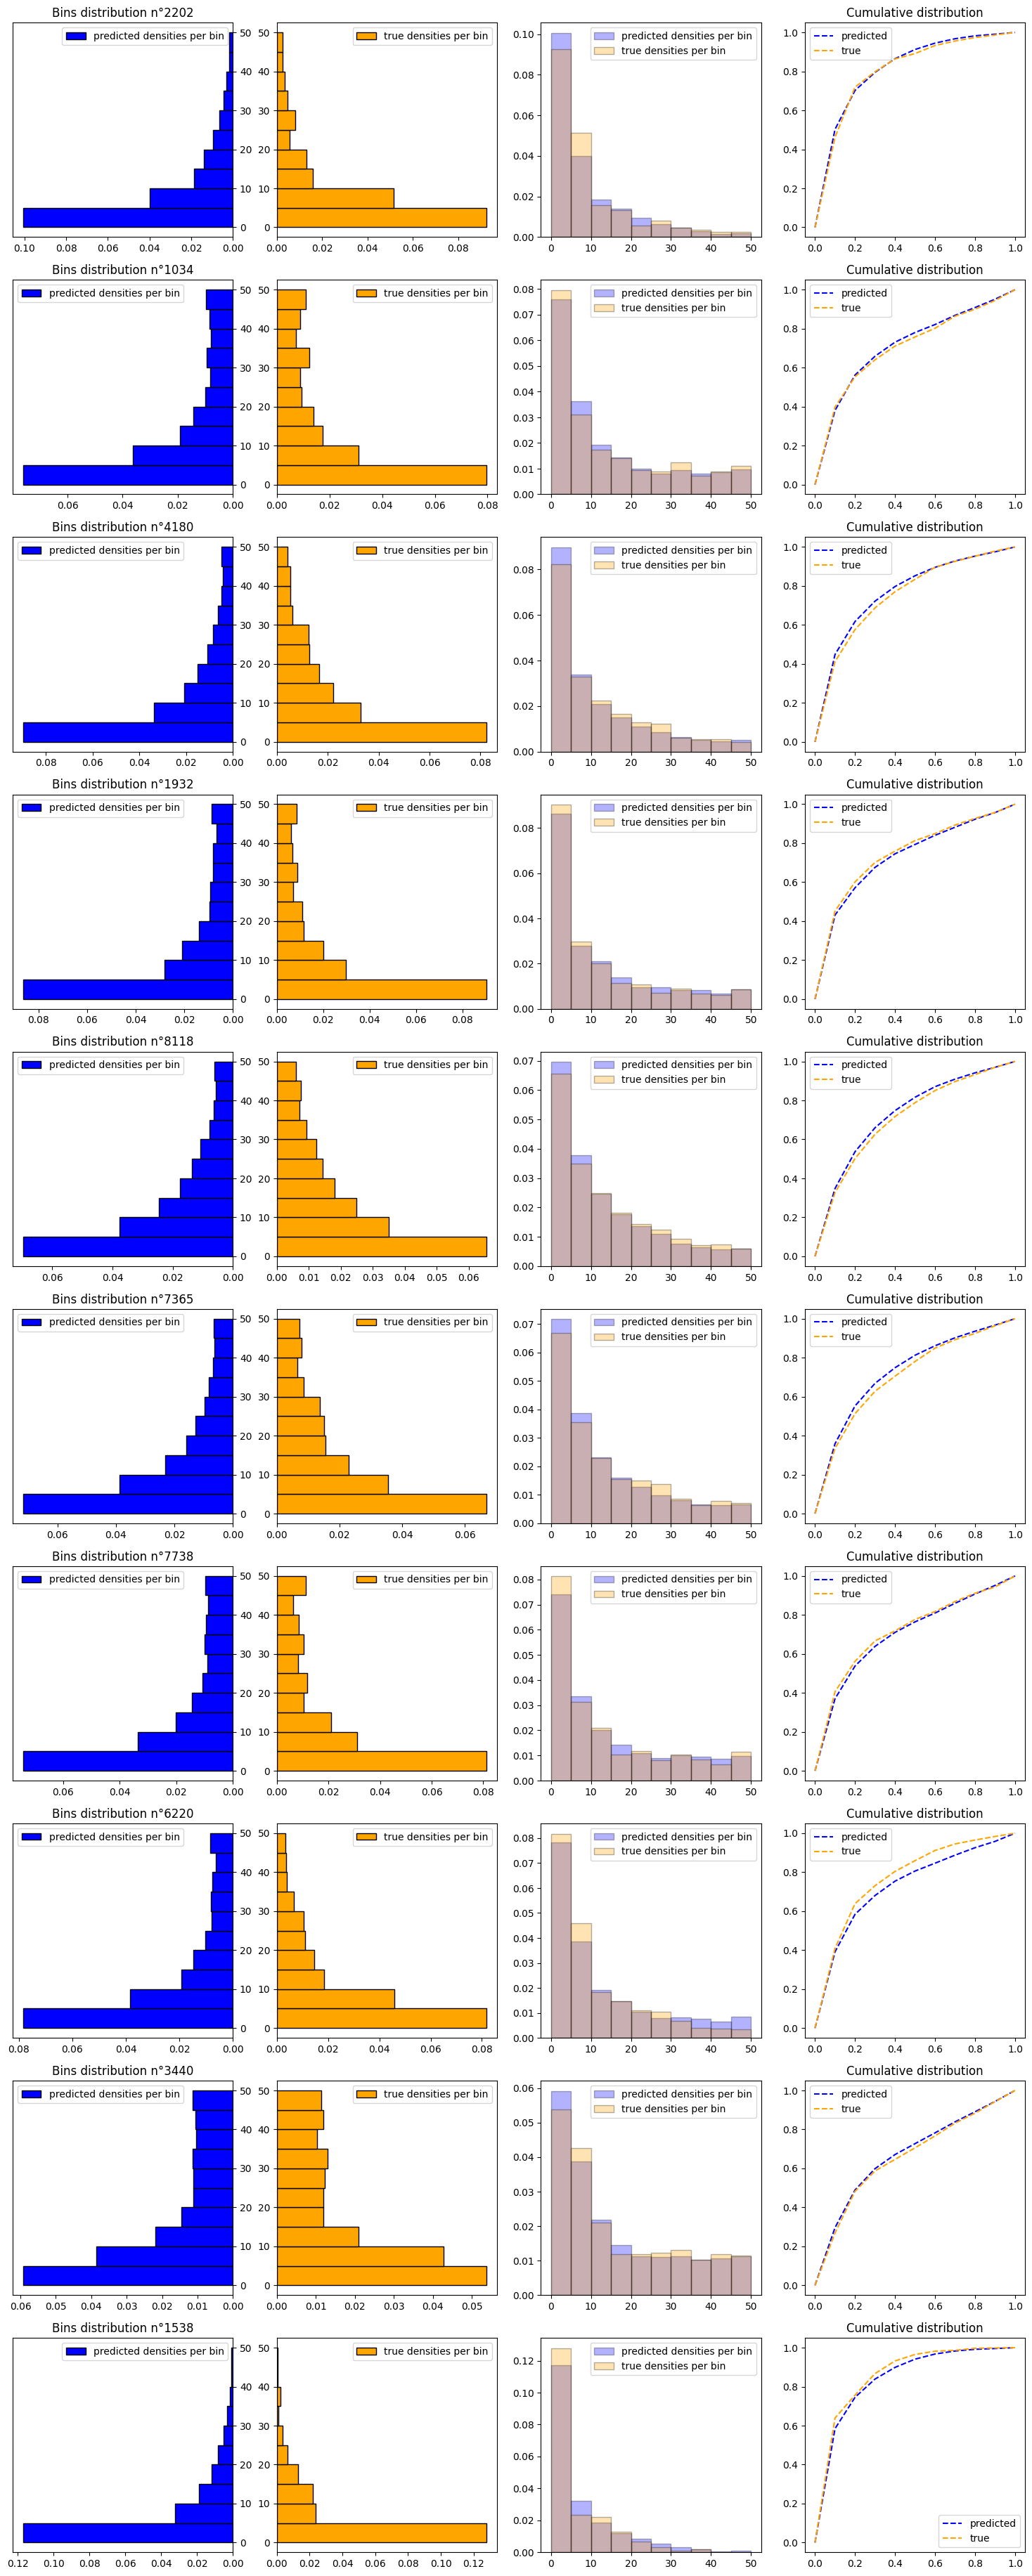

In [28]:
filepath_save_base = path + 'checkpoints_model_bins\\checkpoint'
filepath = 'horizon_23_gafd_rp_3_conv_layer_kullback_leibler'

X = merge_data(inputs['gafd_rp'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

model = tf.keras.models.load_model(filepath_save_base + '_' + filepath + '.hdf5')

n_bins = 10
n_samples = 10
plot_pred_density_percent_per_bins(model, X_val, y_val, n_bins, n_samples, True)
#plot_pred_density_percent_per_bins(filepath_gaf_mtf_rp_ce + '.h5', X_val, y_val, n_bins, n_samples, False, [i for i in range(0, n_samples)])

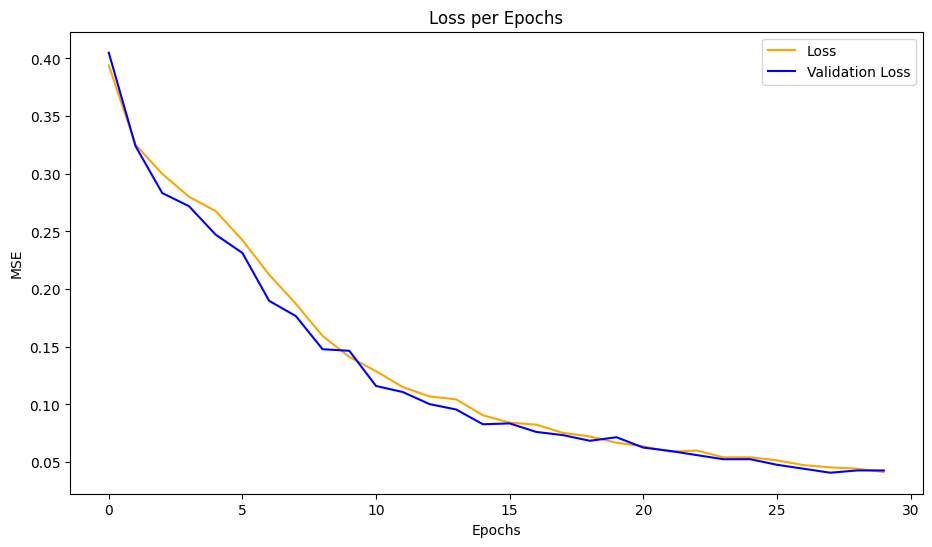

In [45]:
plot_loss_history(filepath_save_base + '_' + filepath + '.hdf5' + '_loss.json')